# FrozenLake [8x8 | random map | no slip]

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import gymnasium as gym
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import cv2
from PIL import Image

plt.style.use(['dark_background', 'seaborn-v0_8'])

# seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Pytorch device:", device)

Pytorch device: cuda


## export raw training img -> video

In [15]:
import os


def count_files(dir_path: str) -> int:
    return sum(
        1 for entry in os.scandir(dir_path)
        if entry.is_file()
    )


f"files/pics/{count_files("files/pics/") + 1:04d}.png"

'files/pics/0001.png'

In [32]:
# !rm files/pics/*

In [ ]:
# !ffmpeg -framerate 2 -i files/pics/%04d.png -c:v libx264 -pix_fmt yuv420p files/output-1.mp4

## Img Wrapper

In [33]:
class FrozenLakeImageWrapper(gym.ObservationWrapper):
    def __init__(self, env, img_size=(84, 84), grayscale=False):
        super().__init__(env)
        self.img_size = img_size
        self.grayscale = grayscale
        channels = 1 if grayscale else 3
        self.observation_space = gym.spaces.Box(
            low=0, high=255,
            shape=(*img_size, channels),
            dtype=np.uint8
        )

    def observation(self, _):
        frame = self.env.render()
        if frame is None:
            channels = 1 if self.grayscale else 3
            return np.zeros((*self.img_size, channels), dtype=np.uint8)

        # Convert to PIL Image
        img = Image.fromarray(frame)

        # Grayscale conversion
        if self.grayscale:
            img = img.convert('L')

        # Resize
        img = img.resize(self.img_size, Image.NEAREST)
        img.save(f"files/pics/{count_files("files/pics/") + 1:04d}.png")  #!DEBUG!#
        obs = np.array(img, dtype=np.uint8)

        # Add channel dimension for grayscale
        if self.grayscale:
            obs = np.expand_dims(obs, axis=-1)

        return obs


def preprocess_frame(frame, resize=(84, 84), grayscale=True):
    """For testing preprocessing"""
    img = Image.fromarray(frame)
    if grayscale:
        img = img.convert('L')
    img = img.resize(resize, Image.NEAREST)
    return np.array(img)


In [34]:
class RandomMapResetWrapper(gym.Wrapper):
    def __init__(self, env, size=8, p=0.8, change_every=1):
        super().__init__(env)
        self.size = size
        self.p = p
        self.change_every = change_every
        self.episode_count = 0
        self.current_desc = None
        self._make_env_with_random_map()

    def _make_env_with_random_map(self):
        new_desc = generate_random_map(size=self.size, p=self.p)
        self.current_desc = tuple(new_desc)
        self.env = gym.make(
            "FrozenLake-v1",
            desc=new_desc,
            is_slippery=self.env.spec.kwargs.get("is_slippery", False),
            render_mode=self.env.render_mode
        )

    def reset(self, **kwargs):
        self.episode_count += 1
        if (self.episode_count - 1) % self.change_every == 0:
            # Time to change map
            self._make_env_with_random_map()
        return self.env.reset(**kwargs)

    def step(self, action):
        return self.env.step(action)

In [35]:
class FrozenLakeCNN(nn.Module):
    def __init__(self, action_size, grayscale=True):
        super().__init__()
        self.grayscale = grayscale
        channels = 1 if grayscale else 3

        self.conv = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )

        # Calculate feature size: ((84-8)//4 + 1) = 20 → ((20-4)//2 +1)=9 → (9-3+1)=7
        self.fc = nn.Sequential(
            nn.Linear(64 * 18 * 18, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)
        )

    def forward(self, x):
        # x shape: (B, H, W, C) → (B, C, H, W)
        x = x.permute(0, 3, 1, 2).float() / 255.0
        return self.fc(self.conv(x))

In [36]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

In [37]:
class DQNAgent:
    def __init__(self, modelClass, state_size, action_size, lr=1e-3, gamma=0.99,
                 buffer_size=10000, batch_size=64, target_update=100):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update = target_update

        # Q-network and target network
        self.q_net = modelClass(state_size, action_size).to(device)
        self.target_net = modelClass(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)

        # Sync target network
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.memory = ReplayBuffer(buffer_size)
        self.step_count = 0

    def act(self, state, epsilon=0.0):
        if random.random() < epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.q_net(state)
        return q_values.argmax().item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        # sample batch
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.BoolTensor(dones).to(device)

        # current q-values
        current_q_values = self.q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # next q-values frm target network
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * next_q_values * (~dones))

        # compute loss
        loss = nn.MSELoss()(current_q_values, target_q_values)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network periodically
        self.step_count += 1
        if self.step_count % self.target_update == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())


In [38]:
def create_env(render_mode=None, use_image=False, img_size=(84, 84), grayscale=True,
               random_map_every_reset=True, change_every=1):
    env = gym.make("FrozenLake8x8-v1", is_slippery=False, render_mode=render_mode)
    if random_map_every_reset:
        env = RandomMapResetWrapper(env, size=8, p=0.85, change_every=change_every)
    if use_image:
        env = FrozenLakeImageWrapper(env, img_size=img_size, grayscale=grayscale)
        state_shape = (*img_size, 1 if grayscale else 3)
    else:
        state_shape = env.observation_space.n
    action_size = env.action_space.n
    return env, state_shape, action_size


def train_dqn(agent, env, state_shape, action_size,
              episodes=2000,
              max_steps=100,
              epsilon_start=1.0,
              epsilon_end=0.01,
              epsilon_decay=0.995, ):
    global history_rewards, history_epsilons

    scores = deque(maxlen=100)
    recent_maps = deque(maxlen=100)

    epsilon = epsilon_start
    print("Starting training...")

    env.start_recording()

    for episode in range(episodes):
        state, _ = env.reset()
        # state is now image - no one-hot needed
        total_reward = 0

        current_map = getattr(env.env, 'current_desc', None)
        recent_maps.append(current_map)

        for t in range(max_steps):
            action = agent.act(state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # --- REWARD SHAPING ---
            shaped_reward = reward
            if not truncated and terminated:
                if reward == 1.0:
                    shaped_reward = 1.0  # goal
                else:
                    shaped_reward = -1.0  # hole
            else:
                # # Penalize stuck moves (only in discrete mode!)
                # print('-~>', next_state, state)
                # if next_state == state:
                #     shaped_reward += -0.1  # strong penalty for no-op
                # else:
                shaped_reward += -0.01  # small step penalty

            agent.remember(state, action, shaped_reward, next_state, done)
            agent.replay()

            state = next_state
            total_reward += shaped_reward

            if done:
                break

        scores.append(total_reward)
        epsilon = max(epsilon_end, epsilon_decay * epsilon)
        history_rewards.append(np.mean(scores))
        history_epsilons.append(epsilon)

        if episode % 100 == 0:
            unique_maps = len(set(m for m in recent_maps if m is not None))
            print(f"Episode {episode}, Avg Reward: {np.mean(scores):.3f}, "
                  f"Epsilon: {epsilon:.3f}, Unique Maps (last 100): {unique_maps}")

        if episode % 1500 == 0 and episode > 0:
            render_env, _, _ = create_env(render_mode="human", use_image=True, random_map_every_reset=True)
            evaluate_agent(agent, render_env, episodes=2, no_log=True)
            render_env.close()

    return agent, env


def evaluate_agent(agent, env, episodes=10, max_steps=1000, no_log=False):
    """
    Evaluate agent on pixel-based environment.
    - Works with both image and discrete state spaces
    """
    success = 0
    for _ in range(episodes):
        state, _ = env.reset()
        for step in range(max_steps):
            action = agent.act(state, epsilon=0.0)  # Greedy policy
            state, reward, terminated, truncated, _ = env.step(action)

            if terminated or truncated:
                if reward == 1.0:  # Reached goal
                    success += 1
                break

    if not no_log:
        print(f"\nSuccess rate: {success}/{episodes} ({100 * success / episodes:.1f}%)")
    return success


def act(self, state, epsilon=0.0):
    if random.random() < epsilon:
        return random.randrange(self.action_size)
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    with torch.no_grad():
        q_values = self.q_net(state_tensor)
    return q_values.argmax().item()

## training loop

In [41]:
grayscale = True

_, _, action_size = create_env(use_image=False)
env, state_shape, _ = create_env(
    render_mode="rgb_array",
    use_image=True,
    img_size=(84, 84),
    grayscale=grayscale,
    random_map_every_reset=True,
    change_every=2_000)

agent = DQNAgent(
    modelClass=lambda s, a: FrozenLakeCNN(a, grayscale=grayscale),
    state_size=None,  # Not used
    action_size=action_size,
    lr=1e-4,
    gamma=0.99,
    buffer_size=20_000,
    batch_size=2_000,
    target_update=100
)

history_rewards, history_epsilons = [], []

Starting training...
Episode 0, Avg Reward: -1.000, Epsilon: 0.999, Unique Maps (last 100): 1
Episode 100, Avg Reward: -1.048, Epsilon: 0.904, Unique Maps (last 100): 1
Episode 200, Avg Reward: -1.048, Epsilon: 0.818, Unique Maps (last 100): 1
Episode 300, Avg Reward: -1.047, Epsilon: 0.740, Unique Maps (last 100): 1
Episode 400, Avg Reward: -1.067, Epsilon: 0.670, Unique Maps (last 100): 1
Episode 500, Avg Reward: -1.093, Epsilon: 0.606, Unique Maps (last 100): 1
Episode 600, Avg Reward: -1.076, Epsilon: 0.548, Unique Maps (last 100): 1
Episode 700, Avg Reward: -1.087, Epsilon: 0.496, Unique Maps (last 100): 1
Episode 800, Avg Reward: -1.134, Epsilon: 0.449, Unique Maps (last 100): 1
Episode 900, Avg Reward: -1.119, Epsilon: 0.406, Unique Maps (last 100): 1
Model: FrozenLakeCNN


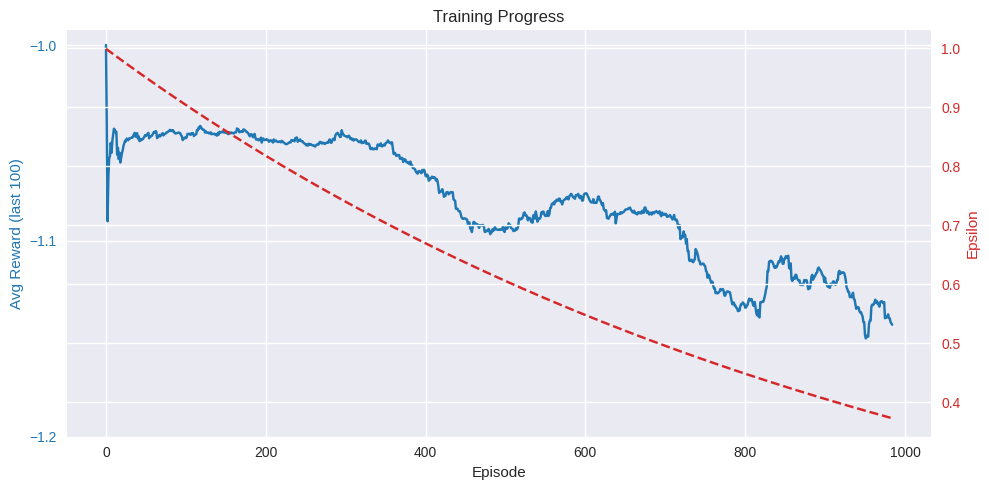

KeyboardInterrupt: 

In [42]:
try:
    agent, env = train_dqn(
        agent=agent,
        env=env,
        state_shape=state_shape,
        action_size=action_size,
        episodes=2_000,
        max_steps=500,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=0.999,
    )
finally:
    # Plotting code (unchanged)
    print(f"Model: {FrozenLakeCNN.__name__}")
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = 'tab:blue'
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Avg Reward (last 100)', color=color)
    ax1.plot(history_rewards, color=color, label='Avg Reward')
    ax1.tick_params(axis='y', labelcolor=color)

    if len(history_rewards) > 0:
        y_min = np.floor(min(history_rewards) * 10) / 10
        y_max = np.ceil(max(history_rewards) * 10) / 10
        ax1.set_yticks(np.arange(y_min, y_max + 0.05, 0.1))

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Epsilon', color=color)
    ax2.plot(history_epsilons, color=color, label='Epsilon', linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Training Progress')
    fig.tight_layout()
    plt.show()

In [ ]:
eval_env, _, _ = create_env(render_mode="human", use_image=True, random_map_every_reset=True)
evaluate_agent(agent, eval_env, episodes=5)
eval_env.close()

It isnt working at all.
Trying MLP

# Approach 2: using MLP

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import gymnasium as gym
import matplotlib.pyplot as plt
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import os
from PIL import Image
import shutil
from collections import deque as dq

plt.style.use(['dark_background', 'seaborn-v0_8'])

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch device:", device)

PyTorch device: cuda


In [2]:
def count_files(dir_path: str) -> int:
    os.makedirs(dir_path, exist_ok=True)
    return sum(1 for entry in os.scandir(dir_path) if entry.is_file())


def clear_dir(dir_path: str):
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

In [3]:
def is_solvable(desc):
    size = len(desc)
    grid = [list(row) for row in desc]
    if grid[size - 1][size - 1] == 'H':
        return False
    visited = [[False] * size for _ in range(size)]
    q = dq([(0, 0)])
    visited[0][0] = True
    while q:
        x, y = q.popleft()
        if (x, y) == (size - 1, size - 1):
            return True
        for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < size and 0 <= ny < size and not visited[nx][ny] and grid[nx][ny] != 'H':
                visited[nx][ny] = True
                q.append((nx, ny))
    return False


def generate_solvable_map(size=8, p=0.85, max_attempts=50):
    for _ in range(max_attempts):
        desc = generate_random_map(size=size, p=p)
        if is_solvable(desc):
            return desc
    # Fallback
    return generate_random_map(size=size, p=p)

In [4]:
class FrozenLakeFullMapWrapper(gym.ObservationWrapper):
    def __init__(self, env, img_size=(84, 84), record_dir="files/pics"):
        super().__init__(env)
        self.img_size = img_size
        self.record_dir = record_dir
        self.episode_frame_count = 0
        # Output: (H, W, 3) → [grayscale, x_coord, y_coord]
        self.observation_space = gym.spaces.Box(
            low=-1.0, high=255.0,
            shape=(*img_size, 3),
            dtype=np.float32
        )
        os.makedirs(record_dir, exist_ok=True)

    def observation(self, _):
        frame = self.env.render()
        if frame is None:
            return np.zeros((*self.img_size, 3), dtype=np.float32)

        # Resize to target
        img = Image.fromarray(frame).resize(self.img_size, Image.NEAREST)
        gray = np.array(img.convert('L'), dtype=np.float32)  # (H, W)

        H, W = self.img_size
        x = np.linspace(-1, 1, W, dtype=np.float32)
        y = np.linspace(-1, 1, H, dtype=np.float32)
        x_ch = np.tile(x, (H, 1))  # (H, W)
        y_ch = np.tile(y[:, None], (1, W))  # (H, W)

        # Stack: [gray, x, y] → (H, W, 3)
        obs = np.stack([gray, x_ch, y_ch], axis=-1)

        # Save frame for video (only during training episodes)
        if hasattr(self, '_recording') and self._recording:
            img.save(os.path.join(self.record_dir, f"{self.episode_frame_count:05d}.png"))
            self.episode_frame_count += 1

        return obs

    def start_recording(self):
        self._recording = True
        self.episode_frame_count = 0

    def stop_recording(self):
        self._recording = False

In [5]:
class RandomMapResetWrapper(gym.Wrapper):
    def __init__(self, env, size=8, p=0.85, change_every=1):
        super().__init__(env)
        self.size = size
        self.p = p
        self.change_every = change_every
        self.episode_count = 0
        self.current_desc = None
        self._make_env_with_random_map()

    def _make_env_with_random_map(self):
        new_desc = generate_solvable_map(size=self.size, p=self.p)
        self.current_desc = tuple(new_desc)
        self.env = gym.make(
            "FrozenLake-v1",
            desc=new_desc,
            is_slippery=False,
            render_mode="rgb_array"
        )

    def reset(self, **kwargs):
        self.episode_count += 1
        if (self.episode_count - 1) % self.change_every == 0:
            old_desc = self.current_desc
            self._make_env_with_random_map()
            print(f"New map (ep {self.episode_count}): changed from {old_desc[:2]}... to {self.current_desc[:2]}...")
        return self.env.reset(**kwargs)

    def step(self, action):
        return self.env.step(action)

In [6]:
class FrozenLakeFullMapCNN(nn.Module):
    def __init__(self, action_size):
        super().__init__()
        # Input: (B, 3, H, W) → [gray, x, y]
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )
        # For 84x84 → 18x18 → 64*18*18 = 20736
        self.fc = nn.Sequential(
            nn.Linear(64 * 18 * 18, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)
        )

    def forward(self, x):
        # x: (B, H, W, 3) → permute to (B, 3, H, W)
        x = x.permute(0, 3, 1, 2)
        x[:, 0] = x[:, 0] / 255.0  # normalize grayscale only
        # x[:, 1:] already in [-1,1]
        return self.fc(self.conv(x))

In [7]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return map(np.stack, zip(*batch))

    def __len__(self):
        return len(self.buffer)


class DQNAgent:
    def __init__(self, modelClass, action_size, lr=1e-4, gamma=0.99,
                 buffer_size=20000, batch_size=64, target_update=100):
        self.action_size = action_size
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update = target_update

        self.q_net = modelClass(action_size).to(device)
        self.target_net = modelClass(action_size).to(device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)

        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.memory = ReplayBuffer(buffer_size)
        self.step_count = 0

    def act(self, state, epsilon=0.0):
        if random.random() < epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.q_net(state)
        return q_values.argmax().item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        # sample batch
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.BoolTensor(dones).to(device)

        # current q-values
        current_q_values = self.q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # next q-values frm target network
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * next_q_values * (~dones))

        # compute loss
        loss = nn.MSELoss()(current_q_values, target_q_values)

        # optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network periodically
        self.step_count += 1
        if self.step_count % self.target_update == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())


In [11]:
def create_env(render_mode="rgb_array", record_dir="files/pics", change_every=500):
    env = gym.make("FrozenLake8x8-v1", is_slippery=False, render_mode=render_mode)
    env = RandomMapResetWrapper(env, size=8, p=0.85, change_every=change_every)
    env = FrozenLakeFullMapWrapper(env, img_size=(84, 84), record_dir=record_dir)
    state_shape = (84, 84, 3)
    action_size = env.action_space.n
    return env, state_shape, action_size


def train_dqn(agent, env, state_shape, action_size,
              episodes=5000,
              max_steps=200,
              epsilon_start=1.0,
              epsilon_end=0.01,
              epsilon_decay=0.995,
              change_every=100):
    global history_rewards, history_epsilons
    scores = deque(maxlen=100)
    epsilon = epsilon_start
    print("Starting training with full map observation...")

    # Start recording ALL episodes
    env.start_recording()

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0

        for t in range(max_steps):
            action = agent.act(state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Reward shaping
            if not truncated and terminated:
                shaped_reward = 1.0 if reward == 1.0 else -1.0
            else:
                shaped_reward = -0.01

            agent.remember(state, action, shaped_reward, next_state, done)
            agent.replay()

            state = next_state
            total_reward += shaped_reward
            if done:
                break

        scores.append(total_reward)
        epsilon = max(epsilon_end, epsilon_decay * epsilon)
        history_rewards.append(np.mean(scores))
        history_epsilons.append(epsilon)

        if episode % 100 == 0:
            if scores:
                s = np.array(scores)
                min_r = np.min(s)
                q1 = np.percentile(s, 25)
                mean_r = np.mean(s)
                q3 = np.percentile(s, 75)
                max_r = np.max(s)
                reward_stats = f"{min_r:6.3f} | {q1:6.3f} | {mean_r:6.3f} | {q3:6.3f} | {max_r:6.3f}"
            else:
                reward_stats = "  N/A  |   N/A |   N/A |   N/A |  N/A "

            print(f"Ep {episode:4d} | R: {reward_stats} | ε: {epsilon:.3f}")

        if (episode > 0) and (episode % change_every == 0):
            epsilon = max(epsilon, 0.5)

    # Stop recording after all episodes
    env.stop_recording()
    return agent, env


## Training loop

In [12]:
# Clear old frames
clear_dir("files/pics")

# Create env (with full map observation)
env, state_shape, action_size = create_env(change_every=10_000)

agent = DQNAgent(
    modelClass=FrozenLakeFullMapCNN,
    action_size=action_size,
    lr=1e-4,
    gamma=0.99,
    buffer_size=20000,
    batch_size=64,
    target_update=100
)

history_rewards, history_epsilons = [], []

Starting training with full map observation...
🆕 New map (ep 1): changed from ('SFFFHFFF', 'HFFFFFFF')... to ('SFFFFFFH', 'FFFFFFFH')...
Ep    0 | R: -1.150 | -1.150 | -1.150 | -1.150 | -1.150 | ε: 1.000
Ep  100 | R: -1.910 | -1.473 | -1.290 | -1.157 |  0.510 | ε: 0.951
Ep  200 | R: -1.890 | -1.423 | -1.298 | -1.170 |  0.600 | ε: 0.904
Ep  300 | R: -1.970 | -1.528 | -1.375 | -1.190 |  0.430 | ε: 0.860
Ep  400 | R: -1.910 | -1.400 | -1.281 | -1.150 |  0.300 | ε: 0.818
Ep  500 | R: -1.860 | -1.380 | -1.187 | -1.150 |  0.810 | ε: 0.778
Ep  600 | R: -1.980 | -1.473 | -1.253 | -1.140 |  0.750 | ε: 0.740
Ep  700 | R: -1.970 | -1.410 | -1.265 | -1.130 |  0.720 | ε: 0.704
Ep  800 | R: -1.960 | -1.483 | -1.254 | -1.150 |  0.640 | ε: 0.670
Ep  900 | R: -1.980 | -1.360 | -1.159 | -1.107 |  0.700 | ε: 0.637
Ep 1000 | R: -1.890 | -1.353 | -0.890 | -1.088 |  0.840 | ε: 0.606
Ep 1100 | R: -1.570 | -1.142 | -0.223 |  0.700 |  0.850 | ε: 0.577
Ep 1200 | R: -1.430 | -1.172 | -0.114 |  0.760 |  0.850 | ε

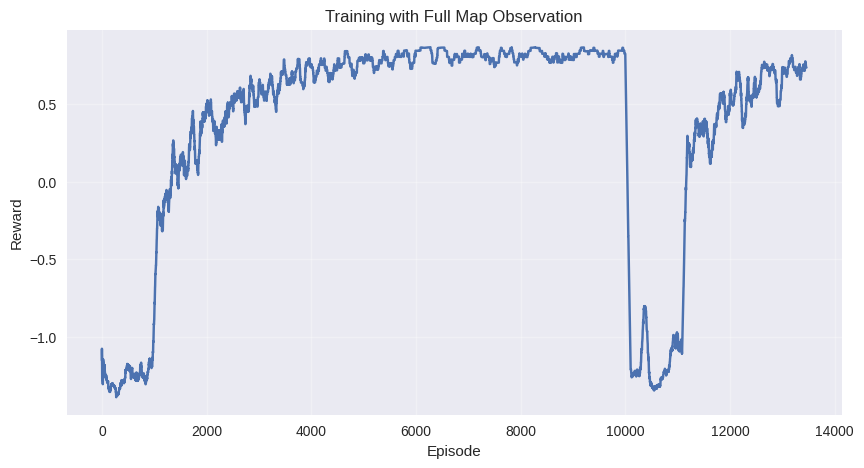

KeyboardInterrupt: 

In [13]:
try:
    agent, env = train_dqn(
        agent=agent,
        env=env,
        state_shape=state_shape,
        action_size=action_size,
        episodes=20_000,
        max_steps=200,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay=0.9995,
        change_every=10_000,
    )
finally:
    # Compile ONE FINAL VIDEO from all frames
    total_frames = count_files("files/pics/")
    if total_frames > 0:
        print(f"Compiling final video from {total_frames} frames...")
        video_path = "files/full_training_run.mp4"
        os.system(
            f"ffmpeg -y -framerate 10 -i files/pics/%05d.png "
            f"-c:v libx264 -pix_fmt yuv420p -vf 'scale=840:840:flags=neighbor' {video_path} > /dev/null 2>&1"
        )
        print(f"Final video saved: {video_path}")
    else:
        print("⚠No frames saved!")

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(history_rewards, label='Avg Reward (100 eps)')
    plt.xlabel('Episode');
    plt.ylabel('Reward')
    plt.title('Training with Full Map Observation')
    plt.grid(True, alpha=0.3)
    plt.show()

Starting training with full map observation...
🆕 New map (ep 1): changed from ('SFFFFFFF', 'FHFFFFFF')... to ('SFHHFFFF', 'FFFFFFFH')...
Ep    0 | R: -1.020 | -1.020 | -1.020 | -1.020 | -1.020 | ε: 0.995
Ep  100 | R: -1.730 | -1.270 | -1.194 | -1.070 | -1.000 | ε: 0.603
Ep  200 | R: -1.930 | -1.280 | -1.218 | -1.098 | -1.010 | ε: 0.365
Ep  300 | R: -1.830 | -1.370 | -1.269 | -1.130 | -1.000 | ε: 0.221
Ep  400 | R: -1.980 | -1.463 | -1.306 | -1.050 | -1.000 | ε: 0.134
Ep  500 | R: -1.970 | -1.555 | -1.317 | -1.000 | -1.000 | ε: 0.081
Ep  600 | R: -1.980 | -1.510 | -1.262 | -1.000 | -1.000 | ε: 0.050
Compiling final video from 278279 frames...
Final video saved: files/full_training_run.mp4


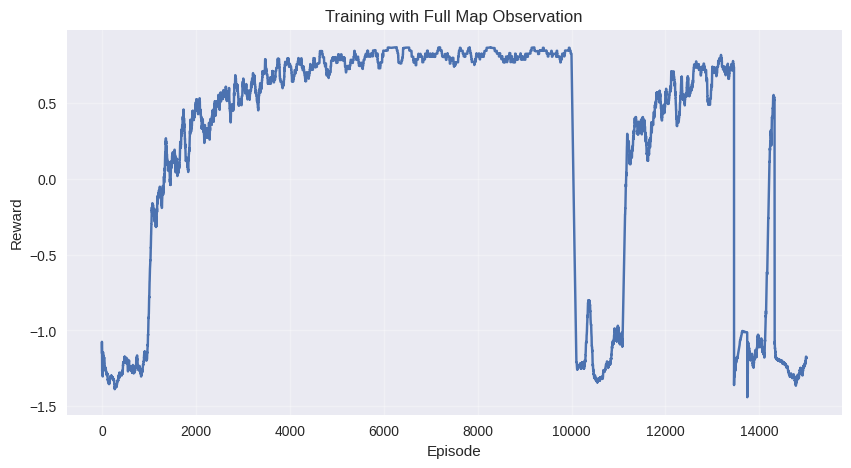

KeyboardInterrupt: 

In [16]:
## TEST
try:
    env, state_shape, action_size = create_env(change_every=1_000)
    agent, env = train_dqn(
        agent=agent,
        env=env,
        state_shape=state_shape,
        action_size=action_size,
        episodes=20_000,
        max_steps=200,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay=0.995,
        change_every=1_000,
    )
finally:
    # Compile ONE FINAL VIDEO from all frames
    total_frames = count_files("files/pics/")
    if total_frames > 0:
        print(f"Compiling final video from {total_frames} frames...")
        video_path = "files/full_training_run.mp4"
        os.system(
            f"ffmpeg -y -framerate 10 -i files/pics/%05d.png "
            f"-c:v libx264 -pix_fmt yuv420p -vf 'scale=840:840:flags=neighbor' {video_path} > /dev/null 2>&1"
        )
        print(f"Final video saved: {video_path}")
    else:
        print("⚠No frames saved!")

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(history_rewards, label='Avg Reward (100 eps)')
    plt.xlabel('Episode');
    plt.ylabel('Reward')
    plt.title('Training with Full Map Observation')
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
# Evaluate on new random maps
print("Final Evaluation on 5 new random maps:")
eval_env, _, _ = create_env(render_mode=None, random_map_every_reset=True, change_every=1)
evaluate_agent(agent, eval_env, episodes=5)
eval_env.close()

# Approach 3: parallel training

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import gymnasium as gym
from gymnasium.vector import SyncVectorEnv
import matplotlib.pyplot as plt
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import os
from PIL import Image
import shutil
from collections import deque as dq

plt.style.use(['dark_background', 'seaborn-v0_8'])

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch device:", device)

PyTorch device: cuda


In [2]:
def count_files(dir_path: str) -> int:
    os.makedirs(dir_path, exist_ok=True)
    return sum(1 for entry in os.scandir(dir_path) if entry.is_file())


def clear_dir(dir_path: str):
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

In [3]:
def is_solvable(desc):
    size = len(desc)
    grid = [list(row) for row in desc]
    if grid[size - 1][size - 1] == 'H':
        return False
    visited = [[False] * size for _ in range(size)]
    q = dq([(0, 0)])
    visited[0][0] = True
    while q:
        x, y = q.popleft()
        if (x, y) == (size - 1, size - 1):
            return True
        for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < size and 0 <= ny < size and not visited[nx][ny] and grid[nx][ny] != 'H':
                visited[nx][ny] = True
                q.append((nx, ny))
    return False


def generate_solvable_map(size=8, p=0.85, max_attempts=50):
    for _ in range(max_attempts):
        desc = generate_random_map(size=size, p=p)
        if is_solvable(desc):
            return desc
    return generate_random_map(size=size, p=p)

In [4]:
class FrozenLakeFullMapWrapper(gym.ObservationWrapper):
    def __init__(self, env, img_size=(84, 84), record_dir="files/pics"):
        super().__init__(env)
        self.img_size = img_size
        self.record_dir = record_dir
        self.episode_frame_count = 0
        # Output: (H, W, 3) → [grayscale, x_coord, y_coord]
        self.observation_space = gym.spaces.Box(
            low=-1.0, high=255.0,
            shape=(*img_size, 3),
            dtype=np.float32
        )
        os.makedirs(record_dir, exist_ok=True)

    def observation(self, _):
        frame = self.env.render()
        if frame is None:
            return np.zeros((*self.img_size, 3), dtype=np.float32)

        # Resize to target
        img = Image.fromarray(frame).resize(self.img_size, Image.NEAREST)
        gray = np.array(img.convert('L'), dtype=np.float32)  # (H, W)

        H, W = self.img_size
        x = np.linspace(-1, 1, W, dtype=np.float32)
        y = np.linspace(-1, 1, H, dtype=np.float32)
        x_ch = np.tile(x, (H, 1))  # (H, W)
        y_ch = np.tile(y[:, None], (1, W))  # (H, W)

        # Stack: [gray, x, y] → (H, W, 3)
        obs = np.stack([gray, x_ch, y_ch], axis=-1)

        # Save frame for video (only during training episodes)
        if hasattr(self, '_recording') and self._recording:
            img.save(os.path.join(self.record_dir, f"{self.episode_frame_count:05d}.png"))
            self.episode_frame_count += 1

        return obs

    def start_recording(self):
        self._recording = True
        self.episode_frame_count = 0

    def stop_recording(self):
        self._recording = False

In [5]:
class RandomMapResetWrapper(gym.Wrapper):
    def __init__(self, env, size=8, p=0.85, change_every=1):
        super().__init__(env)
        self.size = size
        self.p = p
        self.change_every = change_every
        self.episode_count = 0
        self.current_desc = None
        self._make_env_with_random_map()

    def _make_env_with_random_map(self):
        new_desc = generate_solvable_map(size=self.size, p=self.p)
        self.current_desc = tuple(new_desc)
        self.env = gym.make(
            "FrozenLake-v1",
            desc=new_desc,
            is_slippery=False,
            render_mode="rgb_array"
        )

    def reset(self, **kwargs):
        self.episode_count += 1
        if (self.episode_count - 1) % self.change_every == 0:
            old_desc = self.current_desc
            self._make_env_with_random_map()
            print(f"New map (ep {self.episode_count}): changed from {old_desc[:2]}... to {self.current_desc[:2]}...")
        return self.env.reset(**kwargs)

    def step(self, action):
        return self.env.step(action)

In [6]:
class FrozenLakeFullMapCNN(nn.Module):
    def __init__(self, action_size):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 18 * 18, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)
        )

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x[:, 0] = x[:, 0] / 255.0
        return self.fc(self.conv(x))

In [13]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return map(np.stack, zip(*batch))

    def __len__(self):
        return len(self.buffer)


class DQNAgent:
    def __init__(self, modelClass, action_size, lr=1e-4, gamma=0.99,
                 buffer_size=20000, batch_size=64, target_update=100):
        self.action_size = action_size
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update = target_update

        self.q_net = modelClass(action_size).to(device)
        self.target_net = modelClass(action_size).to(device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr, capturable=True)

        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.memory = ReplayBuffer(buffer_size)
        self.step_count = 0

        # CUDA Graphs setup
        self.use_cuda_graphs = (device.type == "cuda")
        self.cuda_graph_recorded = False
        self.replay_graph = None
        self.static_tensors = None

    def act(self, state, epsilon=0.0):
        if random.random() < epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.q_net(state)
        return q_values.argmax().item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        # Use CUDA Graphs if available and ready
        if self.use_cuda_graphs and self.cuda_graph_recorded:
            self._replay_with_graph()
        else:
            self._replay_standard()
            # Try to record graph after first successful replay
            if self.use_cuda_graphs and not self.cuda_graph_recorded:
                self._record_replay_graph()

    def _replay_standard(self):
        """Original replay logic (used for first call and fallback)"""
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.BoolTensor(dones).to(device)

        current_q_values = self.q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * next_q_values * (~dones))
        loss = nn.MSELoss()(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.step_count += 1
        if self.step_count % self.target_update == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

    def _record_replay_graph(self):
        """Records the CUDA graph for replay"""
        try:
            # Sample a dummy batch to get correct shapes
            states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
            state_shape = states.shape[1:]  # e.g., (84, 84, 3)

            # Allocate static tensors on GPU
            self.static_tensors = {
                'states': torch.zeros((self.batch_size, *state_shape), dtype=torch.float32, device=device),
                'actions': torch.zeros((self.batch_size,), dtype=torch.long, device=device),
                'rewards': torch.zeros((self.batch_size,), dtype=torch.float32, device=device),
                'next_states': torch.zeros((self.batch_size, *state_shape), dtype=torch.float32, device=device),
                'dones': torch.zeros((self.batch_size,), dtype=torch.bool, device=device)
            }

            # Create graph
            self.replay_graph = torch.cuda.CUDAGraph()
            with torch.cuda.graph(self.replay_graph):
                # Forward pass
                current_q = self.q_net(self.static_tensors['states']).gather(
                    1, self.static_tensors['actions'].unsqueeze(1)
                ).squeeze(1)
                with torch.no_grad():
                    next_q = self.target_net(self.static_tensors['next_states']).max(1)[0]
                    target_q = self.static_tensors['rewards'] + (
                            self.gamma * next_q * (~self.static_tensors['dones'])
                    )
                loss = nn.MSELoss()(current_q, target_q)

                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            self.cuda_graph_recorded = True
            print("CUDA Graph recorded for replay()")

        except Exception as e:
            print(f"CUDA Graph recording failed: {e}")
            self.use_cuda_graphs = False

    def _replay_with_graph(self):
        """Replays the recorded CUDA graph with new data"""
        # Copy new data into static tensors (fast GPU-to-GPU copy)
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        self.static_tensors['states'].copy_(torch.FloatTensor(states).to(device))
        self.static_tensors['actions'].copy_(torch.LongTensor(actions).to(device))
        self.static_tensors['rewards'].copy_(torch.FloatTensor(rewards).to(device))
        self.static_tensors['next_states'].copy_(torch.FloatTensor(next_states).to(device))
        self.static_tensors['dones'].copy_(torch.BoolTensor(dones).to(device))

        # Replay the graph
        self.replay_graph.replay()

        # Handle target network update (outside graph, as it's infrequent)
        self.step_count += 1
        if self.step_count % self.target_update == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

In [14]:
def make_env_func(change_every=2000):
    def _thunk():
        env = gym.make("FrozenLake8x8-v1", is_slippery=False, render_mode="rgb_array")
        env = RandomMapResetWrapper(env, size=8, p=0.85, change_every=change_every)
        env = FrozenLakeFullMapWrapper(env, img_size=(84, 84))
        return env

    return _thunk

In [15]:
def format_reward_stats(rewards, window=100):
    """
    Compute and format reward statistics over last `window` episodes.
    Returns a string like: "-1.000 | -1.000 | -1.000 | -1.000 | -1.000"
    (min | Q1 | median | Q3 | max)
    """
    if len(rewards) == 0:
        return "  N/A  |   N/A |   N/A |   N/A |  N/A "
    # Use last `window` episodes
    recent = rewards[-window:]
    if len(recent) == 1:
        r = recent[0]
        return f"{r:6.3f} | {r:6.3f} | {r:6.3f} | {r:6.3f} | {r:6.3f}"
    try:
        min_r = np.min(recent)
        q1 = np.percentile(recent, 25)
        med = np.median(recent)
        q3 = np.percentile(recent, 75)
        max_r = np.max(recent)
        return f"{min_r:6.3f} | {q1:6.3f} | {med:6.3f} | {q3:6.3f} | {max_r:6.3f}"
    except:
        return "  ERR  |   ERR |   ERR |   ERR |  ERR "

In [19]:
def train_dqn_vectorized(agent, envs, action_size,
                         total_steps=200_000,
                         max_steps_per_env=200,
                         epsilon_start=1.0,
                         epsilon_end=0.05,
                         epsilon_decay=0.99995):
    global history_rewards, history_epsilons
    num_envs = envs.num_envs
    all_episode_rewards = []
    epsilon = epsilon_start

    # Reset all envs
    states, _ = envs.reset()
    total_rewards = np.zeros(num_envs)

    print(f"Training with {num_envs} parallel environments...")

    for step in range(total_steps):
        # Act for all envs
        actions = []
        for i in range(num_envs):
            action = agent.act(states[i], epsilon)
            actions.append(action)

        # Step all envs
        next_states, rewards, terminations, truncations, _ = envs.step(actions)
        dones = terminations | truncations

        # Store transitions & track rewards
        for i in range(num_envs):
            shaped_reward = -1.0 if (terminations[i] and rewards[i] == 0.0) else (
                1.0 if (terminations[i] and rewards[i] == 1.0) else -0.01
            )
            agent.remember(states[i], actions[i], shaped_reward, next_states[i], dones[i])
            total_rewards[i] += shaped_reward

            if dones[i]:
                all_episode_rewards.append(total_rewards[i])
                total_rewards[i] = 0

        # Train agent
        agent.replay()

        # Update state
        states = next_states
        epsilon = max(epsilon_end, epsilon_decay * epsilon)

        # per step logging for smoother graph
        # history_rewards.append(float(np.mean(rewards)))
        if all_episode_rewards:
            history_rewards.append(float(np.mean(all_episode_rewards[-max_steps_per_env:])))
        else:
            history_rewards.append(0.0)
        history_epsilons.append(epsilon)

        # Logging
        if step % (1000 // num_envs) == 0:
            reward_stats = format_reward_stats(all_episode_rewards, window=max_steps_per_env)
            print(f"Step {step:6d} | R: {reward_stats} | ε: {epsilon:.3f}")

        # force exploration after each 10k step
        if step % 10_000 == 0:
            epsilon = max(epsilon, 0.75)

    return agent, envs

# todo log avg episode count

## training loop

In [20]:
clear_dir("files/pics")

# Create 8 parallel environments
num_envs = 2
envs = SyncVectorEnv([make_env_func(change_every=10_000) for _ in range(num_envs)])
_, sample_obs = envs.reset()
action_size = envs.single_action_space.n

# Create agent
agent = DQNAgent(
    modelClass=FrozenLakeFullMapCNN,
    action_size=action_size,
    lr=1e-4,
    gamma=0.99,
    buffer_size=200_000,
    batch_size=384,
    target_update=3000,
)

history_rewards, history_epsilons = [], []

New map (ep 1): changed from ('SFFFFHFH', 'FFFFHFHF')... to ('SFFFFFFF', 'FFFFHFFF')...
New map (ep 1): changed from ('SFFHFFHF', 'FFFFFFHF')... to ('SFFFFFFF', 'FFFFFHFF')...


Training with 2 parallel environments...
Step      0 | R:   N/A  |   N/A |   N/A |   N/A |  N/A  | ε: 1.000
CUDA Graph recorded for replay()
Step    500 | R: -1.750 | -1.415 | -1.205 | -1.105 | -1.010 | ε: 0.951
Step   1000 | R: -1.750 | -1.325 | -1.200 | -1.100 |  0.020 | ε: 0.905
Step   1500 | R: -2.000 | -1.378 | -1.225 | -1.103 |  0.020 | ε: 0.861
Step   2000 | R: -2.000 | -1.385 | -1.220 | -1.115 |  0.020 | ε: 0.819
Step   2500 | R: -2.000 | -1.388 | -1.230 | -1.110 |  0.250 | ε: 0.779
Step   3000 | R: -2.000 | -1.403 | -1.235 | -1.110 |  0.610 | ε: 0.741
Step   3500 | R: -2.000 | -1.400 | -1.240 | -1.110 |  0.610 | ε: 0.705
Step   4000 | R: -2.000 | -1.390 | -1.230 | -1.120 |  0.610 | ε: 0.670
Step   4500 | R: -2.000 | -1.413 | -1.240 | -1.127 |  0.610 | ε: 0.638
Step   5000 | R: -1.950 | -1.400 | -1.240 | -1.130 |  0.610 | ε: 0.606
Step   5500 | R: -1.950 | -1.403 | -1.230 | -1.130 |  0.610 | ε: 0.577
Step   6000 | R: -1.990 | -1.400 | -1.230 | -1.137 |  0.610 | ε: 0.549
Step   

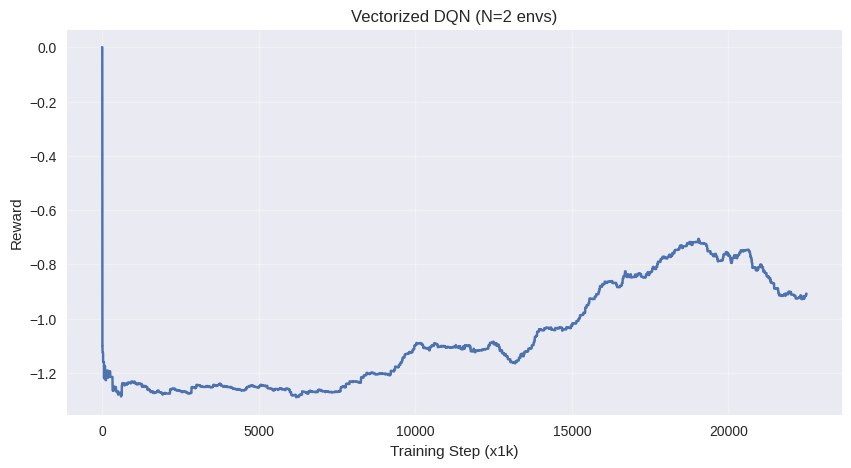

KeyboardInterrupt: 

In [21]:
try:
    agent, envs = train_dqn_vectorized(
        agent=agent,
        envs=envs,
        action_size=action_size,
        total_steps=500_000,  # ~25k episodes total
        max_steps_per_env=200,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay=0.9999
    )
finally:
    envs.close()
    plt.figure(figsize=(10, 5))
    plt.plot(history_rewards, label='Avg Reward')
    plt.xlabel('Training Step (x1k)');
    plt.ylabel('Reward')
    plt.title(f'Vectorized DQN (N={num_envs} envs)')
    plt.grid(True, alpha=0.3)
    plt.show()

## evaluation

In [ ]:
class RecordingWrapper(gym.ObservationWrapper):
    def __init__(self, env, record_dir="files/pics"):
        super().__init__(env)
        self.record_dir = record_dir
        os.makedirs(record_dir, exist_ok=True)
        self.frame_count = 0

    def observation(self, obs):
        frame = self.env.render()
        if frame is not None:
            img = Image.fromarray(frame)
            img.save(os.path.join(self.record_dir, f"{self.frame_count:05d}.png"))
            self.frame_count += 1
        return obs

In [ ]:
# Create single eval env with recording
eval_env = gym.make("FrozenLake8x8-v1", is_slippery=False, render_mode="rgb_array")
eval_env = RandomMapResetWrapper(eval_env, size=8, p=0.85, change_every=1)
eval_env = RecordingWrapper(eval_env)

success = 0
for ep in range(5):
    state, _ = eval_env.reset()
    for _ in range(200):
        action = agent.act(state, epsilon=0.0)
        state, reward, terminated, truncated, _ = eval_env.step(action)
        if terminated or truncated:
            if reward == 1.0:
                success += 1
            break

print(f"\nFinal success rate: {success}/5 ({100 * success / 5:.1f}%)")

# Compile evaluation video
total_frames = count_files("files/pics/")
if total_frames > 0:
    os.system(
        f"ffmpeg -y -framerate 5 -i files/pics/%05d.png "
        f"-c:v libx264 -pix_fmt yuv420p files/evaluation_run.mp4 > /dev/null 2>&1"
    )
    print("Evaluation video saved: files/evaluation_run.mp4")

#